In [1]:
%matplotlib inline
# import, do some set up
# from __future__ import division

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

[ 12  18  26  37  48  52  51  57  67  71  72  74  73  76  78  78  84  88
  90  91  91  91  91  92  94  93  92  93  91  88  91  90  90  90  86  91
 104 110 101 113 126 129  78 120 132 129 128 124 106 112 122 125 122 122
 123 122 103  94  88  90  42  44  48  63  83  91 101 100 100 100 100  98
  96  94  91  90  85  77  64  32  18  25  25  35  52  57  56  59  56  59
  61  63  63  61  54  50  58  49  53  56  55  48  42  35  25  13   1   0
   0   0   0   0   1   2   3   4   8   7   7  11  17  20  24  26  26  27
  27  26  24  25  25  24  25  26  25  24  24  23  23  22  21  20  19  18
  16  16  15  14  12   9   6   2   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   1   2   5   8   9   4   2   5  11  12   9   8   8
  11  12  12  12  12  12  12  12  11  11  11  11  10  11  11  11  10   9
   9   8   8   7   7   7   6   6   5   5   5   4   4   4   4   3   3   3
   3   2   2   1   1   0   0   0]


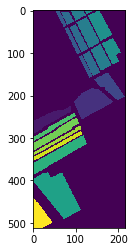

In [2]:
# read from file
data = sio.loadmat('Salinas.mat') # 512*217*204
gt = sio.loadmat('Salinas_gt.mat')
X = data['salinas']
# normalize X to 0-255
# X = X[:,:,0:126]
X -= np.amin(X)
X = X / np.amax(X)
X *= 255
X = np.int16(X)
print (X[10, 100, :])
Y = gt['salinas_gt']
Y[Y==8] = 0
Y[Y==9] = 8
Y[Y==10] = 9
Y[Y==11] = 10
Y[Y==12] = 11
Y[Y==13] = 12
Y[Y==14] = 13
Y[Y==15] = 0
Y[Y==16] = 14
plt.imshow(Y)
plt.show()

In [3]:
# label = 14
# class1 = X[Y==label, :]
# for i in xrange(np.sum(Y==label)):
#     plt.plot(class1[i, :])
# plt.show()
# # X[Y==1, :]

In [4]:
"""Converts a dataset to tfrecords."""
# Magic attribute generated for "int64_list" proto field.
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Magic attribute generated for "bytes_list" proto field.
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to(images, labels, name):
    """
    image: N*Row*Col*depth
    """
    num_examples = labels.shape[0]
    if images.shape[0] != num_examples:
        raise ValueError("Images size %d does not match label size %d." %
                     (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]
    #将多个路径组合后返回
    filename = os.path.join('salinas_dataset', name + '.tfrecords')
    print('Writing', filename)
    #打开tfr文件，并写入数据
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        # Magic attribute generated for "features" proto field
        example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(rows),
        'width': _int64_feature(cols),
        'depth': _int64_feature(depth),
        'label': _int64_feature(int(labels[index])),
        'image_raw': _bytes_feature(image_raw)})
        )
        writer.write(example.SerializeToString())
    writer.close()

In [5]:
num_samples = 500
train = 400
test = 100
# salinas 224
cols = 224
classk_train = {}
classk_test = {}
np.random.seed(1)
# 在同一类中随去选取400个训练样本，从400个样本中选取所有像素对，一组共400*399个
for k in range(1, np.amax(Y)+1):
    classk = X[Y==k, :]
    # np.random.permutation(k)[i:j]在k的范围内随机选j-i个数
    permutation_train = np.random.permutation(classk.shape[0])[:train]
    permutation_test = np.random.permutation(classk.shape[0])[train:num_samples]
    classk_train[k] = classk[permutation_train, :]
    classk_test[k] = classk[permutation_test, :]
    train_samples = np.zeros((train*(train-1), 1, cols, 1), dtype=np.uint8)
    test_samples = np.zeros((test*(test-1), 1, cols, 1), dtype=np.uint8)
    index = 0
    for i in range(train):
        for j in range(train):
            if i==j:
                continue
            # 像素对进行相减，取绝对值
            train_samples[index, :, :, 0] = np.abs(classk_train[k][i, :] - classk_train[k][j, :])
#             print train_samples[index, :, :, 0]
#             raw_input()
            index += 1
    # 同一类设置标签为1
    convert_to(train_samples, np.ones(train*(train-1), dtype=np.int64), str(k)+'train')
    index = 0
    for i in range(test):
        for j in range(test):
            if i==j:
                continue
            test_samples[index, :, :, 0] = np.abs(classk_test[k][i, :] - classk_test[k][j, :])
#             print test_samples[index, :, :, 0]
            index += 1
    # 同一类设置标签为1
    convert_to(test_samples, np.ones(test*(test-1), dtype=np.int64), str(k)+'test')

Writing salinas_dataset\1train.tfrecords
Writing salinas_dataset\1test.tfrecords
Writing salinas_dataset\2train.tfrecords
Writing salinas_dataset\2test.tfrecords
Writing salinas_dataset\3train.tfrecords
Writing salinas_dataset\3test.tfrecords
Writing salinas_dataset\4train.tfrecords
Writing salinas_dataset\4test.tfrecords
Writing salinas_dataset\5train.tfrecords
Writing salinas_dataset\5test.tfrecords
Writing salinas_dataset\6train.tfrecords
Writing salinas_dataset\6test.tfrecords
Writing salinas_dataset\7train.tfrecords
Writing salinas_dataset\7test.tfrecords
Writing salinas_dataset\8train.tfrecords
Writing salinas_dataset\8test.tfrecords
Writing salinas_dataset\9train.tfrecords
Writing salinas_dataset\9test.tfrecords
Writing salinas_dataset\10train.tfrecords
Writing salinas_dataset\10test.tfrecords
Writing salinas_dataset\11train.tfrecords
Writing salinas_dataset\11test.tfrecords
Writing salinas_dataset\12train.tfrecords
Writing salinas_dataset\12test.tfrecords
Writing salinas_datase

In [6]:
# salinas
# 从两个不同的类中选取像素对，其中一类选取400个样本，另一类选取400/13个样本，一组共400×int(400/13)*13
# 不同类的训练样本选取
classes = np.amax(Y)
n = int(train / (classes-1))
np.random.seed(1)
for i in range(classes):
    train_samples = np.zeros((train*n*(classes-1), 1, cols, 1), dtype=np.uint8)
    index = 0
    for j in range(classes):
        if i==j:
            continue
        temp_samples = classk_train[j+1][np.random.permutation(train)[:n], :]
        for k in range(train):
            for m in range(n):
                train_samples[index, 0, :, 0] = np.abs(classk_train[i+1][k, :] - temp_samples[m, :])
#                 print train_samples[index, 0, :, 0]
                index += 1
    # 不同类的标签设置为0
    convert_to(train_samples, np.zeros(train*n*(classes-1), dtype=np.int64), str(i+classes+1)+'train')

Writing salinas_dataset\15train.tfrecords
Writing salinas_dataset\16train.tfrecords
Writing salinas_dataset\17train.tfrecords
Writing salinas_dataset\18train.tfrecords
Writing salinas_dataset\19train.tfrecords
Writing salinas_dataset\20train.tfrecords
Writing salinas_dataset\21train.tfrecords
Writing salinas_dataset\22train.tfrecords
Writing salinas_dataset\23train.tfrecords
Writing salinas_dataset\24train.tfrecords
Writing salinas_dataset\25train.tfrecords
Writing salinas_dataset\26train.tfrecords
Writing salinas_dataset\27train.tfrecords
Writing salinas_dataset\28train.tfrecords


In [7]:
# salinas
# 不同类的测试样本选取
n = int(test / (classes-1))
np.random.seed(1)
for i in range(classes):
    test_samples = np.zeros((test*n*(classes-1), 1, cols, 1), dtype=np.uint8)
    index = 0
    for j in range(classes):
        if i==j:
            continue
        temp_samples = classk_test[j+1][np.random.permutation(test)[:n], :]
        for k in range(test):
            for m in range(n):
                test_samples[index, 0, :, 0] = np.abs(classk_test[i+1][k, :] - temp_samples[m, :])
                index += 1
    # 不同类的标签设置为0
    convert_to(test_samples, np.zeros(test*n*(classes-1), dtype=np.int64), str(i+classes+1)+'test')

Writing salinas_dataset\15test.tfrecords
Writing salinas_dataset\16test.tfrecords
Writing salinas_dataset\17test.tfrecords
Writing salinas_dataset\18test.tfrecords
Writing salinas_dataset\19test.tfrecords
Writing salinas_dataset\20test.tfrecords
Writing salinas_dataset\21test.tfrecords
Writing salinas_dataset\22test.tfrecords
Writing salinas_dataset\23test.tfrecords
Writing salinas_dataset\24test.tfrecords
Writing salinas_dataset\25test.tfrecords
Writing salinas_dataset\26test.tfrecords
Writing salinas_dataset\27test.tfrecords
Writing salinas_dataset\28test.tfrecords
